**This project utilize python and beautifulsoup to scrap weather data from the web.** 
**The case study area for this analysis is Tallahassee, FL**

In [25]:
#Import libraries
from bs4 import BeautifulSoup
import requests
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Request url and pass it through beautifulsoup
page = requests.get("https://forecast.weather.gov/MapClick.php?lat=30.4398&lon=-84.2806#.XIsgVihKiHs")
soup = BeautifulSoup(page.content, 'html.parser')
seven_day = soup.find(id="seven-day-forecast")
forecast_items = seven_day.find_all(class_="tombstone-container")
tonight = forecast_items[0]
print(tonight.prettify())

<div class="tombstone-container">
 <p class="period-name">
  Tonight
  <br/>
  <br/>
 </p>
 <p>
  <img alt="Tonight: Mostly cloudy, with a low around 64. South wind around 5 mph becoming calm. " class="forecast-icon" src="newimages/medium/nbkn.png" title="Tonight: Mostly cloudy, with a low around 64. South wind around 5 mph becoming calm. "/>
 </p>
 <p class="short-desc">
  Mostly Cloudy
 </p>
 <p class="temp temp-low">
  Low: 64 °F
 </p>
</div>


In [5]:
#Finding specific dailiy forecast
period = tonight.find(class_="period-name").get_text()
short_desc = tonight.find(class_="short-desc").get_text()
temp = tonight.find(class_="temp").get_text()

print(period)
print(short_desc)
print(temp)

Tonight
Mostly Cloudy
Low: 64 °F


In [6]:
img = tonight.find("img")
desc = img['title']

print(desc)

Tonight: Mostly cloudy, with a low around 64. South wind around 5 mph becoming calm. 


In [7]:
#This code extract the specific periods for the weather forecast
period_tags = seven_day.select(".tombstone-container .period-name")
periods = [pt.get_text() for pt in period_tags]
periods

['Tonight',
 'Friday',
 'FridayNight',
 'Saturday',
 'SaturdayNight',
 'Sunday',
 'SundayNight',
 'Monday',
 'MondayNight']

In [15]:
#This code scrap all the data into a list of short description, temperature, and 
short_descs = [sd.get_text() for sd in seven_day.select(".tombstone-container .short-desc")]
temps = [t.get_text() for t in seven_day.select(".tombstone-container .temp")]
descs = [d["title"] for d in seven_day.select(".tombstone-container img")]
print(short_descs)
print(temps)
print(descs)

['Mostly Cloudy', 'ChanceShowers thenShowersLikely', 'ShowersLikely', 'Slight ChanceShowers', 'ChanceShowers', 'ChanceShowers', 'Partly Cloudy', 'Mostly Sunny', 'Partly Cloudy']
['Low: 64 °F', 'High: 79 °F', 'Low: 55 °F', 'High: 62 °F', 'Low: 48 °F', 'High: 65 °F', 'Low: 46 °F', 'High: 70 °F', 'Low: 46 °F']
['Tonight: Mostly cloudy, with a low around 64. South wind around 5 mph becoming calm. ', 'Friday: A chance of showers and thunderstorms, then showers likely and possibly a thunderstorm after 2pm.  Mostly cloudy, with a high near 79. South wind 5 to 10 mph.  Chance of precipitation is 60%. New rainfall amounts between a tenth and quarter of an inch, except higher amounts possible in thunderstorms. ', 'Friday Night: Showers likely and possibly a thunderstorm before 8pm, then a chance of showers and thunderstorms between 8pm and 2am, then a slight chance of showers after 2am.  Mostly cloudy, with a low around 55. North wind around 5 mph.  Chance of precipitation is 60%. New rainfall a

In [16]:
#This code use pandas to create a dataframe and pass in the list of all the information we have
import pandas as pd
weather = pd.DataFrame({
        "period": periods,
         "short_desc": short_descs,
         "temp": temps,
         "desc":descs
    })
weather

,period,short_desc,temp,desc
0,Tonight,Mostly Cloudy,Low: 64 °F,"Tonight: Mostly cloudy, with a low around 64. ..."
1,Friday,ChanceShowers thenShowersLikely,High: 79 °F,"Friday: A chance of showers and thunderstorms,..."
2,FridayNight,ShowersLikely,Low: 55 °F,Friday Night: Showers likely and possibly a th...
3,Saturday,Slight ChanceShowers,High: 62 °F,Saturday: A slight chance of showers before 8a...
4,SaturdayNight,ChanceShowers,Low: 48 °F,Saturday Night: A 30 percent chance of showers...
5,Sunday,ChanceShowers,High: 65 °F,Sunday: A 30 percent chance of showers. Mostl...
6,SundayNight,Partly Cloudy,Low: 46 °F,"Sunday Night: Partly cloudy, with a low around..."
7,Monday,Mostly Sunny,High: 70 °F,"Monday: Mostly sunny, with a high near 70."
8,MondayNight,Partly Cloudy,Low: 46 °F,"Monday Night: Partly cloudy, with a low around..."


**We will do some data exploration of the scrapped weather information**

In [21]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

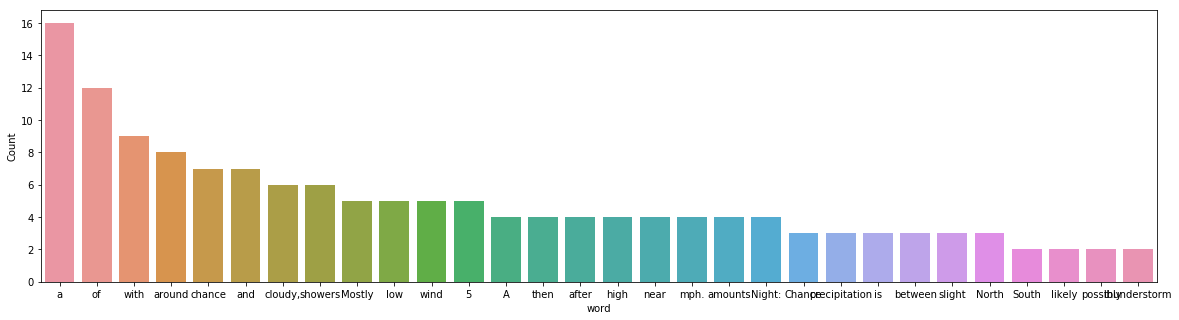

In [26]:
freq_words(weather['desc'])

In [27]:
# remove unwanted characters, numbers and symbols
weather['desc'] = weather['desc'].str.replace("[^a-zA-Z#]", " ")

In [28]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [30]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
weather['desc'] = weather['desc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
description = [remove_stopwords(r.split()) for r in weather['desc']]

# make entire text lowercase
description = [r.lower() for r in description]

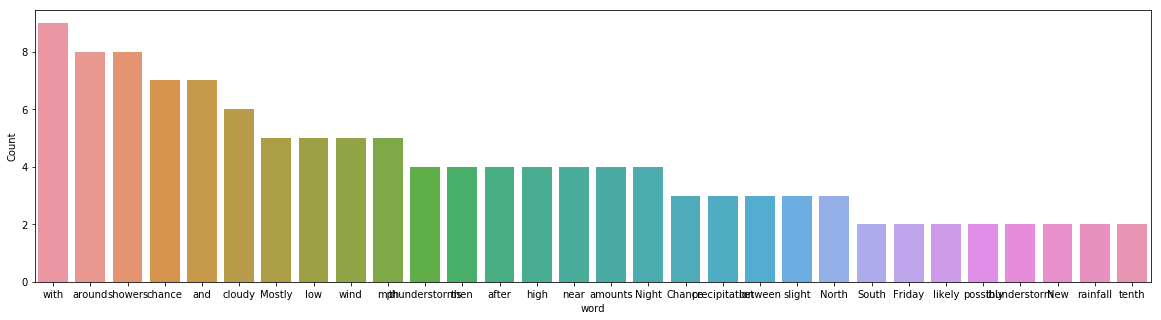

In [31]:
freq_words(weather['desc'])